# 0. Setup Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [6]:
if os.name=='nt':
    !pip install wget
    import wget

In [67]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
# !pip install tensorflow --upgrade

In [ ]:
# !pip uninstall protobuf matplotlib -y
# !pip install protobuf matplotlib==3.2

In [8]:
import object_detection

In [ ]:
# !pip list

In [69]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

100% [........................................................................] 20515344 / 20515344        1 file(s) moved.


x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


# 2. Create Label Map

In [7]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [ ]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [10]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# 4. Copy Model Config to Training Folder

In [11]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


# 5. Update Config For Transfer Learning

In [8]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [9]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [10]:
config

{'model': ssd {
   num_classes: 1
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [11]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [12]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [13]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [14]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [15]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [16]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=10000


In [ ]:
!{command}

# 7. Evaluate the Model

In [17]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [18]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet


In [ ]:
!{command}

# 8. Load Train Model From Checkpoint

In [19]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [20]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [21]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [22]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [23]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'testimg.png')

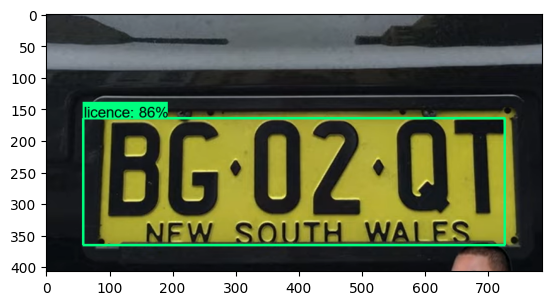

In [24]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [106]:
# pip install easyocr

In [ ]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [25]:
import easyocr

In [26]:
detection_threshold=0.7
image=image_np_with_detections
scores=list(filter(lambda x:x>detection_threshold,detections['detection_scores']))
boxes=detections['detection_boxes'][:len(scores)]
classes=detections['detection_classes'][:len(scores)]
print(scores)

[0.8648832]


In [27]:
width=image.shape[1]
height=image.shape[0]

[0.40767956 0.07420638 0.8991803  0.9258994 ]
[([[28, 0], [669, 0], [669, 169], [28, 169]], 'BG 02 01', 0.15596777555844554), ([[95, 159], [213, 159], [213, 200], [95, 200]], 'NEW', 0.9885317809511028), ([[236, 155], [418, 155], [418, 200], [236, 200]], 'SOUIH', 0.9584775973165742), ([[444, 154], [620, 154], [620, 200], [444, 200]], 'WALES', 0.9997606789842689)]


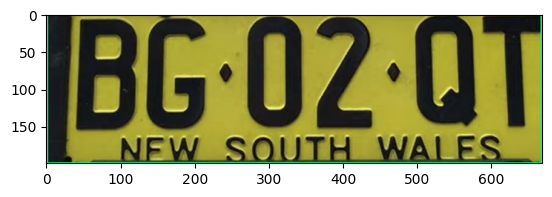

In [28]:
# apply roi filtering and ocr
for idx , box  in enumerate(boxes):
    print(box)
    roi = box*[height,width,height,width]
    region = image[int (roi[0]):int ( roi[2]),int (roi[1]):int ( roi[3])]
    reader=easyocr.Reader(['en'])
    ocr_result=reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region , cv2.COLOR_BGR2RGB))

In [ ]:
# pip uninstall pillow

# OCR FILTERING


In [33]:
region_threshold=0.6

In [34]:
def filter_text(region,ocr_result,region_threshold):
    rectangle_size=region.shape[0]*region.shape[1]
    
    plate=[]
    for result in ocr_result:
        length=np.sum(np.subtract(result[0][1],result[0][0]))
        height=np.sum(np.subtract(result[0][2],result[0][1]))
        
        if(length*height/rectangle_size>region_threshold):
            plate.append(result[1])
#         print(length, height)
    return plate  

In [35]:
filter_text(region,ocr_result,region_threshold)

['BG 02 01']

# Bring it Together

In [36]:
def ocr_it(image,detections,detection_threshold,region_threshold):
    
    # scores, boxes and classes above threshold
    scores=list(filter(lambda x:x>detection_threshold,detections['detection_scores']))
    boxes=detections['detection_boxes'][:len(scores)]
    classes=detections['detection_classes'][:len(scores)]
    
    # full image dimensions
    for idx , box  in enumerate(boxes):
        roi = box*[height,width,height,width]
        region = image[int (roi[0]):int ( roi[2]),int (roi[1]):int ( roi[3])]
        reader=easyocr.Reader(['en'])
        ocr_result=reader.readtext(region)
        
        text=filter_text(region, ocr_result ,region_threshold)
        plt.imshow(cv2.cvtColor(region , cv2.COLOR_BGR2RGB))
        print(text)
        return text,region
    

['BG 02 01']


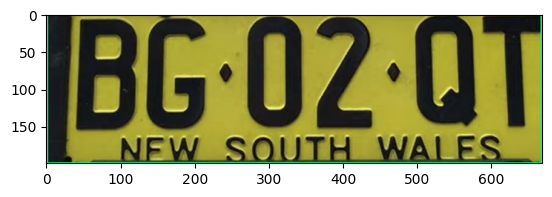

In [37]:
text,region=ocr_it(image_np_with_detections,detections,detection_threshold,region_threshold)

# Save Results


In [42]:
import csv 
import uuid

In [51]:
# def save_results(text,region,csv_filename,folder_path):
#     img_name='{}.jpg'.format(uuid.uuid1())
#     cv2.imwrite(os.path.join(folder_path,img_name),region)
#     with open (csv_filename,mode='a',newline='') as f:
#         csv_writer_obj=csv_writer(f,delimeter=',',quotechar='"',quoting=csv.QUOTE_MINIMAL)
#         csv_write_obj.writerow([img_name,text])
def save_results(text, region, csv_filename, folder_path):
    img_name='{}.jpg'.format(uuid.uuid1())
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer_obj = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer_obj.writerow([img_name, text])

In [52]:
save_results(text,region,'detection_results.csv','Detection_Images')

# 10. Real Time Detections from your Webcam

In [ ]:
!pip uninstall opencv-python-headless -y

['NKT2DE14JJ']


['MHIZ DE1A']
['MH12 DE1A']


['MHIZ DEI']


['HHI2 DEL']


['MHI2DEIA']
['7412 DEIA']


['7kI2 dETAS']


['MHI2DE143']


['MH12DE1433']
['MHIZ DE1433']


['0H1Z |E1AJJ']


['HHIZ DE143']
['HHIZ DE1433']


['HHIZDE1433']
['MHI2DE143']


['NHTFMun']


['MH12 DE1433']


['MH12 DE1433']


['M412 DE1433']


['441? DE1433']


['MH12DE1433']


['MH12 DE1433']
['MH12DE1433']


['MH12 DE1433']


['MH12 DE1433']


['MH12 DE1433']
['MH12 DE1433']


['MH12 DE1433']


['MH12 DE1433']


KeyboardInterrupt: 

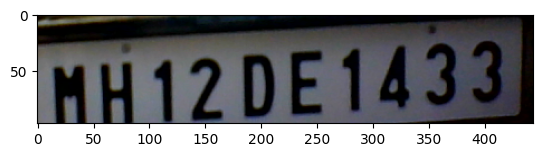

In [53]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    try:
        text,region=ocr_it(image_np_with_detections,detections,detection_threshold,region_threshold)
        save_results(text,region,'realtimeresults.csv','Detection_Images')
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

In [ ]:
# gpus=tf.config.list_physical_devices('GPU')
# print(gpus)

# 10. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')